<a href="https://colab.research.google.com/github/mehedihasanbijoy/How-to-HuggingFace/blob/main/Efficient_Ways_of_LLMs_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- GPU must be enabled to run this notebook.
- This is based on https://github.com/jonkrohn/NLP-with-LLMs/blob/main/code/IMDB-GPU-demo.ipynb

In [1]:
%%capture
!pip install transformers==4.25.1 datasets==2.4.0 nvidia-ml-py3==7.352.0 lime torchvision

In [2]:
# PyTorch:
import torch
import torch.nn.functional as F

# Hugging Face:
from datasets import load_dataset
from transformers import (
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    GPT2ForSequenceClassification,
    GPT2Tokenizer,
)

# NVIDIA Management Library (for tracking GPU usage):
from pynvml import (
    nvmlInit,
    nvmlDeviceGetHandleByIndex,
    nvmlDeviceGetMemoryInfo,
    nvmlDeviceGetCount,
    nvmlDeviceGetName,
)

# Explainability:
from lime.lime_text import LimeTextExplainer
import random

### Utilities for GPU benchmarking

In [3]:
def print_gpu_utilization():
    nvmlInit()
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        info = nvmlDeviceGetMemoryInfo(handle)
        print("Device", i, ":", nvmlDeviceGetName(handle))
        print(f"GPU memory occupied: {info.used//1024**2} MB.")
    torch.cuda.empty_cache()

def print_summary(result):
    print(f"Training Loss: {result.training_loss:.4f}")
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

Set device

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", DEVICE)

Using device cuda


In [5]:
print_gpu_utilization()

Device 0 : b'Tesla T4'
GPU memory occupied: 260 MB.


In [6]:
torch.ones((1, 1)).to(DEVICE) # send a tensor to the GPU
print_gpu_utilization()

Device 0 : b'Tesla T4'
GPU memory occupied: 362 MB.


## Load model

In [7]:
hf_model_name = "microsoft/DialogRPT-updown"

Tokenizer

In [8]:
tokenizer = GPT2Tokenizer.from_pretrained(
    hf_model_name,
    model_max_length=1024,
    cache_dir="./cache/"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model

In [9]:
model = GPT2ForSequenceClassification.from_pretrained(
    hf_model_name,
    num_labels=2, # binary outcome: positive or negative review
    ignore_mismatched_sizes=True, # allows us to have two output neurons on model pre-trained with one
    cache_dir="./cache/",
).to(DEVICE)

model.config.use_cache = False

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialogRPT-updown and are newly initialized because the shapes did not match:
- score.weight: found shape torch.Size([1, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model.config

GPT2Config {
  "_name_or_path": "microsoft/DialogRPT-updown",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2ForSequenceClassification"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1024,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 24,
  "n_positions": 1024,
  "n_special": 0,
  "pad_token_id": 50256,
  "predict_special_tokens": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.25.1",
  "use_cache": false,
  "vocab_size": 502

In [11]:
model

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=1024, out_features=2, bias=False)
)

In [12]:
print_gpu_utilization()

Device 0 : b'Tesla T4'
GPU memory occupied: 1740 MB.


# Load and preprocess data

In [13]:
split = ["train[:25]", "test[:25]"]

raw_train, raw_test = load_dataset(
    "imdb",
    split=split,
    cache_dir="./cache/",
)

  0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
len(raw_train)

25

In [15]:
raw_train[2]["text"]

"If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />"

In [16]:
raw_train[2]["label"]

0

In [17]:
for i in range(25):
  print(raw_train[i]["label"])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [18]:
tokenizer.encode(raw_train[2]["text"])

[1532,
 691,
 284,
 3368,
 1642,
 428,
 2099,
 286,
 2646,
 287,
 262,
 2003,
 13,
 770,
 2646,
 318,
 3499,
 355,
 281,
 6306,
 475,
 4952,
 645,
 43072,
 298,
 1621,
 29847,
 1671,
 1220,
 6927,
 1671,
 11037,
 3198,
 1244,
 1254,
 41276,
 329,
 5586,
 33834,
 340,
 780,
 340,
 18105,
 319,
 523,
 867,
 30023,
 9863,
 8643,
 2428,
 475,
 340,
 857,
 523,
 1231,
 597,
 22024,
 540,
 20289,
 13,
 383,
 19091,
 2058,
 1497,
 351,
 645,
 649,
 22582,
 357,
 25252,
 530,
 2058,
 510,
 351,
 530,
 981,
 530,
 338,
 2000,
 11569,
 364,
 11,
 355,
 340,
 481,
 31338,
 466,
 1141,
 428,
 27158,
 2646,
 737,
 27,
 1671,
 1220,
 6927,
 1671,
 11037,
 3198,
 1244,
 1365,
 4341,
 530,
 338,
 640,
 16143,
 503,
 257,
 4324,
 379,
 257,
 5509,
 3957,
 29847,
 1671,
 1220,
 6927,
 1671,
 11037]

In [19]:
train = raw_train.map(
    lambda x: {"input_ids": tokenizer(x["text"], truncation=True, padding="max_length")["input_ids"]},
    batched=True,
    remove_columns=['text'],
)

test = raw_test.map(
    lambda x: {"input_ids": tokenizer(x["text"], truncation=True, padding="max_length")["input_ids"]},
    batched=True,
    remove_columns=['text'],
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [20]:
train

Dataset({
    features: ['label', 'input_ids'],
    num_rows: 25
})

In [21]:
train.column_names

['label', 'input_ids']

In [22]:
test

Dataset({
    features: ['label', 'input_ids'],
    num_rows: 25
})

# Free Cache Memory

In [23]:
torch.cuda.empty_cache()

In [24]:
print_gpu_utilization()

Device 0 : b'Tesla T4'
GPU memory occupied: 1740 MB.


# Fine-tune Mode

#### Vanilla Training

In [25]:
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "epoch", # "no",
    "num_train_epochs": 10,
    "per_device_train_batch_size": 1,
}

In [26]:
training_args = TrainingArguments(**default_args)
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
jit_mode_eval=False,
label_n

In [27]:
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)

result = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 25
  Num Epochs = 10
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 250
  Number of trainable parameters = 354825216


Epoch,Training Loss,Validation Loss
1,No log,0.000001
2,No log,0.000000
3,No log,0.000000
4,No log,0.000000
5,No log,0.000000
6,No log,0.000000
7,No log,0.000000
8,No log,0.000000
9,No log,0.000000
10,No log,0.000000


***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




In [28]:
print_summary(result)

Training Loss: 0.0125
Time: 290.62
Samples/second: 0.86
Device 0 : b'Tesla T4'
GPU memory occupied: 12148 MB.


# Gradient Accumulation

In [29]:
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "epoch", # "no",
    "num_train_epochs": 10,
    "per_device_train_batch_size": 1,
}
default_args["gradient_accumulation_steps"] = 4

In [30]:
training_args = TrainingArguments(**default_args)
training_args

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=4,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
jit_mode_eval=False,
label_n

In [31]:
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)

result = trainer.train()

***** Running training *****
  Num examples = 25
  Num Epochs = 10
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 60
  Number of trainable parameters = 354825216


Epoch,Training Loss,Validation Loss
0,No log,0.000000
1,No log,0.000000
2,No log,0.000000
3,No log,0.000000
4,No log,0.000000
5,No log,0.000000
6,No log,0.000000
7,No log,0.000000
8,No log,0.000000
9,No log,0.000000


***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




In [32]:
print_summary(result)

Training Loss: 0.0000
Time: 265.45
Samples/second: 0.94
Device 0 : b'Tesla T4'
GPU memory occupied: 13290 MB.


# Gradient Checkpointing

In [33]:
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "epoch", # "no",
    "num_train_epochs": 10,
    "per_device_train_batch_size": 1,
}
default_args["gradient_accumulation_steps"] = 4
default_args["gradient_checkpointing"] = True

In [34]:
training_args = TrainingArguments(**default_args)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [35]:
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)
result = trainer.train()

***** Running training *****
  Num examples = 25
  Num Epochs = 10
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 60
  Number of trainable parameters = 354825216
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,No log,0.000000
1,No log,0.000000
2,No log,0.000000
3,No log,0.000000
4,No log,0.000000
5,No log,0.000000
6,No log,0.000000
7,No log,0.000000
8,No log,0.000000
9,No log,0.000000


***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




In [36]:
print_summary(result)

Training Loss: 0.0000
Time: 336.87
Samples/second: 0.74
Device 0 : b'Tesla T4'
GPU memory occupied: 8606 MB.


# Mixed-Precision Training

In [37]:
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "epoch", # "no",
    "num_train_epochs": 10,
    "per_device_train_batch_size": 1,
}
default_args["gradient_accumulation_steps"] = 4
default_args["gradient_checkpointing"] = True
default_args["fp16"] = True

In [38]:
training_args = TrainingArguments(**default_args)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [39]:
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
)

result = trainer.train()

Using cuda_amp half precision backend
***** Running training *****
  Num examples = 25
  Num Epochs = 10
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 60
  Number of trainable parameters = 354825216


Epoch,Training Loss,Validation Loss
0,No log,0.000000
1,No log,0.000000
2,No log,0.000000
3,No log,0.000000
4,No log,0.000000
5,No log,0.000000
6,No log,0.000000
7,No log,0.000000
8,No log,0.000000
9,No log,0.000000


***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




In [40]:
print_summary(result)

Training Loss: 0.0000
Time: 177.73
Samples/second: 1.41
Device 0 : b'Tesla T4'
GPU memory occupied: 8586 MB.


# Dynamic Padding and Uniform-length Batching

In [41]:
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "epoch", # "no",
    "num_train_epochs": 10,
    "per_device_train_batch_size": 1,
}
default_args["gradient_accumulation_steps"] = 4
default_args["gradient_checkpointing"] = True
default_args["fp16"] = True

In [42]:
training_args = TrainingArguments(**default_args)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [43]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")
collate_fn

DataCollatorWithPadding(tokenizer=PreTrainedTokenizer(name_or_path='microsoft/DialogRPT-updown', vocab_size=50257, model_max_len=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '<|endoftext|>'}), padding='longest', max_length=None, pad_to_multiple_of=None, return_tensors='pt')

In [44]:
train = raw_train.map(lambda x: tokenizer(x["text"], truncation=True), batched=True)
test = raw_test.map(lambda x: tokenizer(x["text"], truncation=True), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [45]:
train

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 25
})

In [46]:
test

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 25
})

In [47]:
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=collate_fn,
)

result = trainer.train()

Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 25
  Num Epochs = 10
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 60
  Number of trainable parameters = 354825216


Epoch,Training Loss,Validation Loss
0,No log,0.000000
1,No log,0.000000
2,No log,0.000000
3,No log,0.000000
4,No log,0.000000
5,No log,0.000000
6,No log,0.000000
7,No log,0.000000
8,No log,0.000000
9,No log,0.000000


The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text. If text are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 25
  Batch size = 8
The following columns 

In [48]:
print_summary(result)

Training Loss: 0.0000
Time: 66.64
Samples/second: 3.75
Device 0 : b'Tesla T4'
GPU memory occupied: 7340 MB.


# Benchmarking / Comparison

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
data = {
    'Method': [
        'Vanilla Training',
        'Gradient Accumulation',
        'Gradient Checkpointing',
        'Mixed-Precision Training',
        'Dynamic Padding and Uniform-length Batching'
    ],
    'Training Loss': [0.0125, 0.0000, 0.0000, 0.0000, 0.0000],
    'Time (s)': [290.62, 265.45, 336.87, 177.73, 66.64],
    'Samples/second': [0.86, 0.94, 0.74, 1.41, 3.75],
    'GPU Memory Occupied (MB)': [12148, 13290, 8606, 8586, 7340]
}

df = pd.DataFrame(data)
df

,Method,Training Loss,Time (s),Samples/second,GPU Memory Occupied (MB)
0,Vanilla Training,0.0125,290.62,0.86,12148
1,Gradient Accumulation,0.0000,265.45,0.94,13290
2,Gradient Checkpointing,0.0000,336.87,0.74,8606
3,Mixed-Precision Training,0.0000,177.73,1.41,8586
4,Dynamic Padding and Uniform-length Batching,0.0000,66.64,3.75,7340


In [54]:
print("\nSummary Statistics:\n")
print(df.describe())


Summary Statistics:

       Training Loss   Time (s)  Samples/second  GPU Memory Occupied (MB)
count        5.00000    5.00000        5.000000                   5.00000
mean         0.00250  227.46200        1.540000                9994.00000
std          0.00559  106.93353        1.261289                2571.77254
min          0.00000   66.64000        0.740000                7340.00000
25%          0.00000  177.73000        0.860000                8586.00000
50%          0.00000  265.45000        0.940000                8606.00000
75%          0.00000  290.62000        1.410000               12148.00000
max          0.01250  336.87000        3.750000               13290.00000


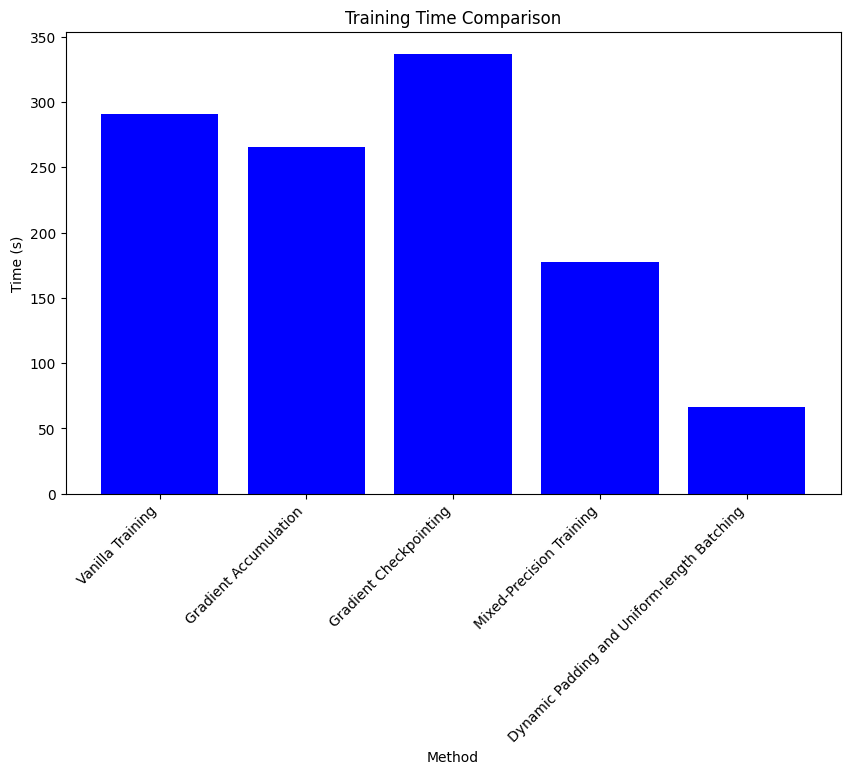

In [56]:
# Plot Time
plt.figure(figsize=(10, 6))
plt.bar(df['Method'], df['Time (s)'], color='blue')
plt.xlabel('Method')
plt.ylabel('Time (s)')
plt.title('Training Time Comparison')
plt.xticks(rotation=45, ha='right')
plt.show()

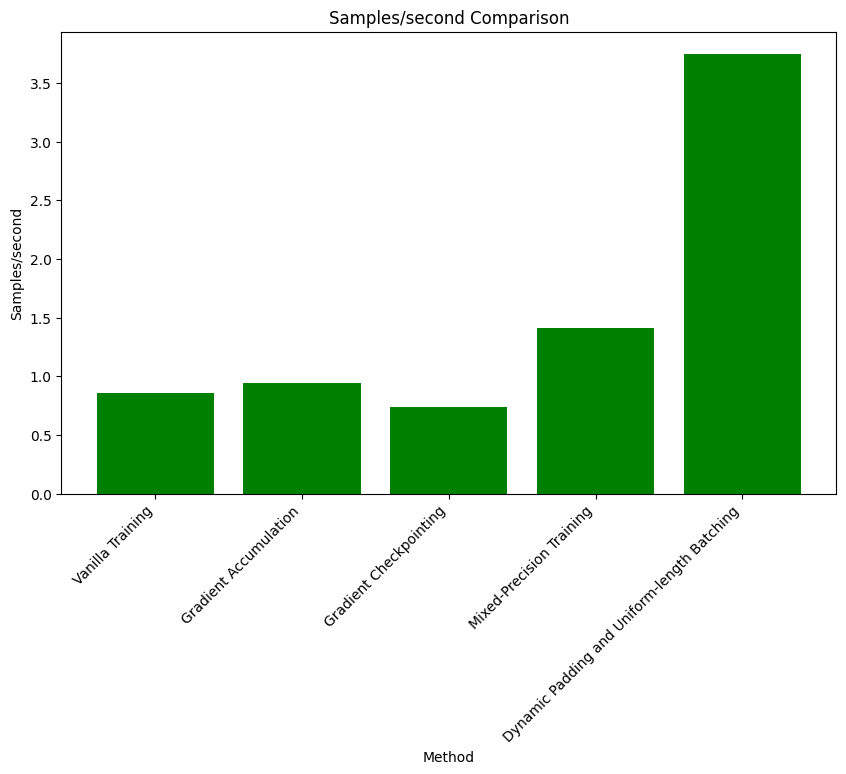

In [57]:
# Plot Samples/second
plt.figure(figsize=(10, 6))
plt.bar(df['Method'], df['Samples/second'], color='green')
plt.xlabel('Method')
plt.ylabel('Samples/second')
plt.title('Samples/second Comparison')
plt.xticks(rotation=45, ha='right')
plt.show()

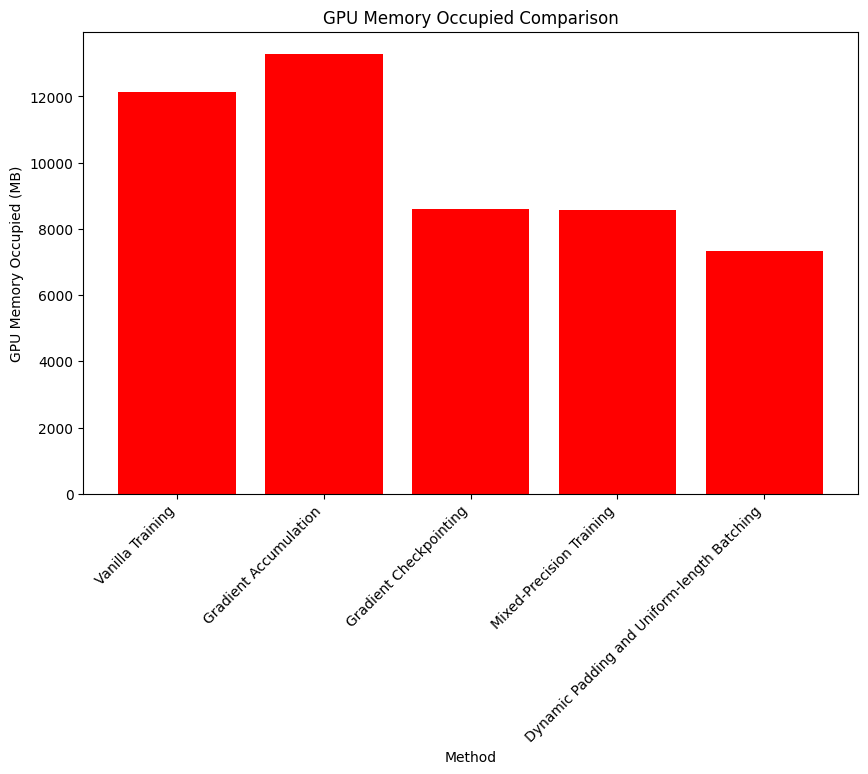

In [58]:
# Plot GPU Memory Occupied
plt.figure(figsize=(10, 6))
plt.bar(df['Method'], df['GPU Memory Occupied (MB)'], color='red')
plt.xlabel('Method')
plt.ylabel('GPU Memory Occupied (MB)')
plt.title('GPU Memory Occupied Comparison')
plt.xticks(rotation=45, ha='right')
plt.show()

In [50]:
# Vanilla Training
# Training Loss: 0.0125
# Time: 290.62
# Samples/second: 0.86
# Device 0 : b'Tesla T4'
# GPU memory occupied: 12148 MB.

# Gradient Accumulation
# Training Loss: 0.0000
# Time: 265.45
# Samples/second: 0.94
# Device 0 : b'Tesla T4'
# GPU memory occupied: 13290 MB.

# Gradient Checkpointing
# Training Loss: 0.0000
# Time: 336.87
# Samples/second: 0.74
# Device 0 : b'Tesla T4'
# GPU memory occupied: 8606 MB.

# Mixed-Precision Training
# Training Loss: 0.0000
# Time: 177.73
# Samples/second: 1.41
# Device 0 : b'Tesla T4'
# GPU memory occupied: 8586 MB.

# Dynamic Padding and Uniform-length Batching
# Training Loss: 0.0000
# Time: 66.64
# Samples/second: 3.75
# Device 0 : b'Tesla T4'
# GPU memory occupied: 7340 MB.